In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input
import numpy as np
import IPython.display
import glob
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir "CleanData"
!mkdir "NoisyData"

!unzip "/content/drive/My Drive/clean_trainset_wav.zip" -d "CleanData"
!unzip "/content/drive/My Drive/noisy_trainset_wav.zip" -d "NoisyData"

mkdir: cannot create directory ‘CleanData’: File exists
mkdir: cannot create directory ‘NoisyData’: File exists
Archive:  /content/drive/My Drive/clean_trainset_wav.zip
replace CleanData/clean_trainset_wav/p226_001.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/drive/My Drive/noisy_trainset_wav.zip
replace NoisyData/noisy_trainset_wav/p226_001.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
clean_sounds = glob.glob('/content/CleanData/clean_trainset_wav/*')
noisy_sounds = glob.glob('/content/NoisyData/noisy_trainset_wav/*')

clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for i in tqdm(clean_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  clean_sounds_list = tf.concat((clean_sounds_list,so),0)

noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for i in tqdm(noisy_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

clean_sounds_list.shape,noisy_sounds_list.shape

  0%|          | 0/3790 [00:00<?, ?it/s]

  0%|          | 0/3790 [00:00<?, ?it/s]

(TensorShape([180851816, 1]), TensorShape([180851816, 1]))

In [ ]:
batching_size = 12000

clean_train,noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
  clean_train.append(clean_sounds_list[i:i+batching_size])
  noisy_train.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

clean_train.shape,noisy_train.shape

  0%|          | 0/15070 [00:00<?, ?it/s]

(TensorShape([15070, 12000, 1]), TensorShape([15070, 12000, 1]))

In [ ]:
def get_dataset(x_train,y_train):
  dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
  dataset = dataset.shuffle(100).batch(64,drop_remainder=True)
  return dataset

In [ ]:
train_dataset = get_dataset(noisy_train[:3200],clean_train[:3200])
test_dataset = get_dataset(noisy_train[500:],clean_train[500:])

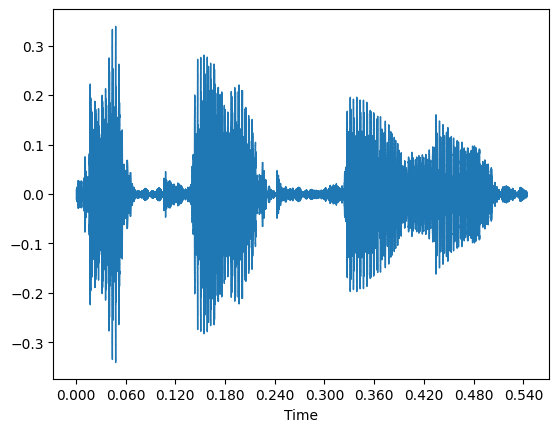

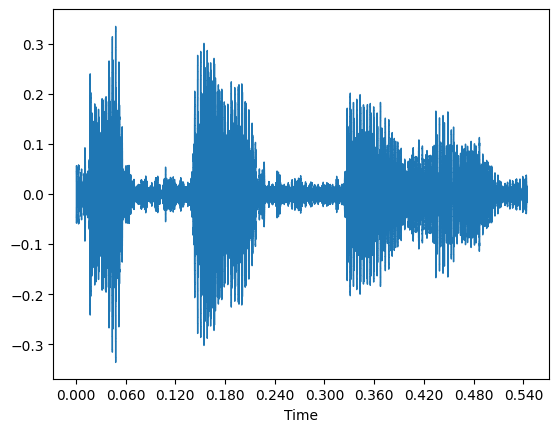

In [ ]:
librosa.display.waveshow(np.squeeze(clean_train[5].numpy(),axis=-1))
plt.show()
librosa.display.waveshow(np.squeeze(noisy_train[5].numpy(),axis=-1))
plt.show()

In [ ]:
inp = Input(shape=(batching_size,1))
c1 = Conv1D(2,32,2,'same',activation='relu')(inp)
c2 = Conv1D(4,32,2,'same',activation='relu')(c1)
c3 = Conv1D(8,32,2,'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(32,32,2,'same',activation='relu')(c4)

dc1 = Conv1DTranspose(32,32,1,padding='same')(c5)
conc = Concatenate()([c5,dc1])
dc2 = Conv1DTranspose(16,32,2,padding='same')(conc)
conc = Concatenate()([c4,dc2])
dc3 = Conv1DTranspose(8,32,2,padding='same')(conc)
conc = Concatenate()([c3,dc3])
dc4 = Conv1DTranspose(4,32,2,padding='same')(conc)
conc = Concatenate()([c2,dc4])
dc5 = Conv1DTranspose(2,32,2,padding='same')(conc)
conc = Concatenate()([c1,dc5])
dc6 = Conv1DTranspose(1,32,2,padding='same')(conc)
conc = Concatenate()([inp,dc6])
dc7 = Conv1DTranspose(1,32,1,padding='same',activation='linear')(conc)
model = tf.keras.models.Model(inp,dc7)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 12000, 1)]           0         []                            
                                                                                                  
 conv1d_5 (Conv1D)           (None, 6000, 2)              66        ['input_2[0][0]']             
                                                                                                  
 conv1d_6 (Conv1D)           (None, 3000, 4)              260       ['conv1d_5[0][0]']            
                                                                                                  
 conv1d_7 (Conv1D)           (None, 1500, 8)              1032      ['conv1d_6[0][0]']            
                                                                                            

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.002),loss=tf.keras.losses.MeanAbsoluteError())
history = model.fit(train_dataset,epochs=20)


Epoch 1/20
50/50 [==============================] - 84s 2s/step - loss: 0.0306
Epoch 2/20
50/50 [==============================] - 84s 2s/step - loss: 0.0213
Epoch 3/20
50/50 [==============================] - 82s 2s/step - loss: 0.0187
Epoch 4/20
50/50 [==============================] - 80s 2s/step - loss: 0.0174
Epoch 5/20
50/50 [==============================] - 81s 2s/step - loss: 0.0165
Epoch 6/20
50/50 [==============================] - 81s 2s/step - loss: 0.0159
Epoch 7/20
50/50 [==============================] - 82s 2s/step - loss: 0.0154
Epoch 8/20
50/50 [==============================] - 82s 2s/step - loss: 0.0149
Epoch 9/20
50/50 [==============================] - 80s 2s/step - loss: 0.0146
Epoch 10/20
50/50 [==============================] - 86s 2s/step - loss: 0.0144
Epoch 11/20
50/50 [==============================] - 80s 2s/step - loss: 0.0140
Epoch 12/20
50/50 [==============================] - 80s 2s/step - loss: 0.0139
Epoch 13/20
50/50 [==============================

In [ ]:
from IPython.display import Audio
Audio(np.squeeze(noisy_train[900].numpy()),rate=16000)

In [ ]:
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[900],-1),0))),rate=16000)

1/1 [==============================] - 0s 390ms/step


In [ ]:
model.evaluate(test_dataset)

227/227 [==============================] - 129s 556ms/step - loss: 0.0131


0.01313598733395338

In [ ]:
model.save('NoiseSuppressionModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def get_audio(path):
  audio,_ = tf.audio.decode_wav(tf.io.read_file(path),1)
  return audio

In [ ]:
def inference_preprocess(path):
  audio = get_audio(path)
  audio_len = audio.shape[0]
  batches = []
  for i in range(0,audio_len-batching_size,batching_size):
    batches.append(audio[i:i+batching_size])

  batches.append(audio[-batching_size:])
  diff = audio_len - (i + batching_size)
  return tf.stack(batches), diff

In [ ]:
def predict(path):
  test_data,diff = inference_preprocess(path)
  predictions = model.predict(test_data)
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((final_op,predictions[-1][-diff:]),axis=0)
  return final_op

In [ ]:
Audio(np.squeeze(get_audio(noisy_sounds[888]).numpy(),-1),rate=16000)

In [ ]:
import librosa

audio, sr = librosa.load(noisy_sounds[888], sr=None)
print("Shape of audio:", audio.shape)



Shape of audio: (34720,)


In [ ]:
# Convert mono audio to stereo
stereo_audio = np.stack((audio, audio), axis=-1)

print("Shape of stereo audio:", stereo_audio.shape)


Shape of stereo audio: (34720, 2)


In [ ]:
print("Shape before squeezing:", stereo_audio.shape)
squeezed = tf.squeeze(stereo_audio)
print("Shape after squeezing:", squeezed.shape)



Shape before squeezing: (34720, 2)
Shape after squeezing: (34720, 2)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 12000, 1)]           0         []                            
                                                                                                  
 conv1d_5 (Conv1D)           (None, 6000, 2)              66        ['input_2[0][0]']             
                                                                                                  
 conv1d_6 (Conv1D)           (None, 3000, 4)              260       ['conv1d_5[0][0]']            
                                                                                                  
 conv1d_7 (Conv1D)           (None, 1500, 8)              1032      ['conv1d_6[0][0]']            
                                                                                            

In [ ]:
lite_model = tf.lite.TFLiteConverter.from_keras_model(model)
lite_model.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = lite_model.convert()

In [ ]:
with open('TFLiteModel.tflite','wb') as f:
  f.write(tflite_model_quant)

In [ ]:
interpreter = tf.lite.Interpreter(model_path='/content/TFLiteModel.tflite')
interpreter.allocate_tensors()

In [ ]:
def predict_tflite(path):
  test_audio,diff = inference_preprocess(path)
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  preds = []
  for i in test_audio:
    interpreter.set_tensor(input_index, tf.expand_dims(i,0))
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    preds.append(predictions)

  predictions = tf.squeeze(tf.stack(preds,axis=1))
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((tf.squeeze(final_op),predictions[-1][-diff:]),axis=0)
  return final_op

In [ ]:
# Original Noisy Audio
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=16000)

In [ ]:
# Clean Audio
Audio(np.squeeze(get_audio(clean_sounds[4]).numpy(),-1),rate=16000)

In [ ]:
# Output Audio
Audio(predict_tflite(noisy_sounds[4]),rate=16000)

In [ ]:
%%timeit
predict_tflite(noisy_sounds[3])

33.8 ms ± 886 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


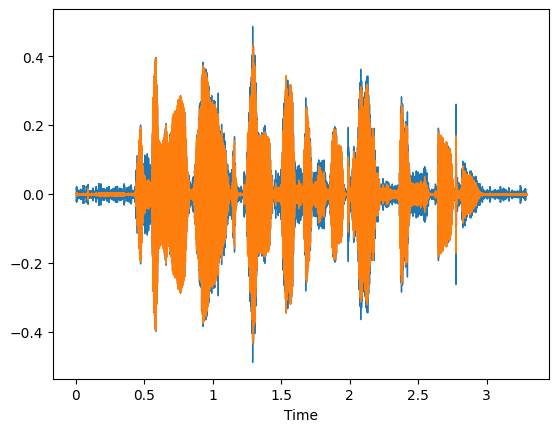

In [ ]:
librosa.display.waveshow(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1))
librosa.display.waveshow(predict_tflite(noisy_sounds[4]).numpy())